## Block Relaxation for NBA Scoring


Reproduces Figure 11.1 in Lange.

In [4]:
library(data.table)

set.seed(1234)

## read data, order times, fold lc, put in x,y,sig variables
dat <- as.data.frame(fread("http://longjp.github.io/statcomp/data/nba_cleaned.txt"))

In [5]:
head(dat)

team1_name,team1_score,team2_name,team2_score,location,nOT,game_length
San Antonio Spurs,87,Los Angeles Lakers,82,Los Angeles,0,48
Orlando Magic,95,Philadelphia 76ers,88,Orlando,0,48
Sacramento Kings,94,Cleveland Cavaliers,67,Sacramento,0,48
Chicago Bulls,99,Boston Celtics,96,Boston,0,48
Detroit Pistons,86,New York Knicks,77,Detroit,0,48
Golden State Warriors,106,San Antonio Spurs,98,Golden State,0,48


In [6]:

team_names <- unique(c(dat$team1_name,dat$team2_name))
n_team <- length(team_names)


## Model Prep

Before fitting the model, we convert the information in the data frame into matrices. This leads to much faster code than for loops. There is also less code.

In [12]:


##### STEP 1: PUT DATA IN NICE MATRICES
## T = t_ij = total time (across all games) 
##            team i played team j (symmetric)
## P = p_ij = total points (across all games)
##            i scores on j (not symmetric)
T <- matrix(0,nrow=n_team,ncol=n_team,dimnames=list(team_names,team_names))
P <- matrix(0,nrow=n_team,ncol=n_team,dimnames=list(team_names,team_names))
for(ii in 1:nrow(T)){
    ## find opponent and game length of opponents for particular row
    out <- subset(dat,team1_name==rownames(T)[ii],select=c("team2_name","team1_score","team2_score","game_length"))
    ## calculate total minutes, points scored, points allowed
    mins <- tapply(out[,4],out[,1],sum)
    ps <- tapply(out[,2],out[,1],sum)
    pg <- tapply(out[,3],out[,1],sum)
    ## record data in matrices
    T[ii,names(mins)] <- mins
    P[ii,names(ps)] <- P[ii,names(ps)] + ps
    P[names(ps),ii] <- P[names(ps),ii] + pg
}
## right now t_ij is time team i played j when team i won
##      thus t_ji is time team i played j when team j won
## by adding transpose we get total time i played j
T <- T + t(T) 


Prs <- rowSums(P) ## \sum_j p_ij
Pcs <- colSums(P) ## \sum_j p_j

## Fit Model with Block Relaxation

In [13]:
## od is matrix of parameter fits for o and d
od <- matrix(0,nrow=n_team,ncol=2)
colnames(od) <- c("o","d")
rownames(od) <- colnames(T)

## N iterations
N <- 1000
for(jj in 1:N){
    od[,2] <- -log(Pcs / colSums(T*exp(od[,1])))
    od[1,2] <- 0 ## force d_1 = 0 for identifiability
    od[,1] <- log(Prs / colSums(t(T)*exp(-od[,2])))
}
## normalize od to 0
od <- od - mean(od)




## Explore Model Output

In [14]:
## team rankings
out <- data.frame(o=od[,1],d=od[,2],rank=rowSums(od))
out[order(out$rank,decreasing=TRUE),]

,o,d,rank
Dallas Mavericks,0.4215041,-0.3411479,0.080356174
Sacramento Kings,0.4066285,-0.3380678,0.068560677
San Antonio Spurs,0.3439711,-0.2828856,0.061085487
New Jersey Nets,0.3414096,-0.2932668,0.048142748
Detroit Pistons,0.2901222,-0.2564915,0.033630702
Portland Trail Blazers,0.3369430,-0.3049073,0.032035695
Utah Jazz,0.3355636,-0.3056435,0.029920032
Indiana Pacers,0.3513442,-0.3217878,0.029556352
Los Angeles Lakers,0.3891876,-0.3614755,0.027712080
Minnesota Timberwolves,0.3721519,-0.3462022,0.025949777


In [15]:
## MAKE PROBABILISTIC PREDICTIONS: DALLAS versus HOUSTON
min <- 48 ## game length
dallas_rate <- min*exp(od["Dallas Mavericks",1] - od["Houston Rockets",2])
houston_rate <- min*exp(od["Houston Rockets",1] - od["Dallas Mavericks",2])
## random draw of scores
n <- 1000
d_score <- rpois(n,lambda=dallas_rate)
h_score <- rpois(n,lambda=houston_rate)


scores <- data.frame(c(rep("dallas",n),rep("houston",n)),c(d_score,h_score))
colnames(scores) <- c("team","points")




[1] 0.663

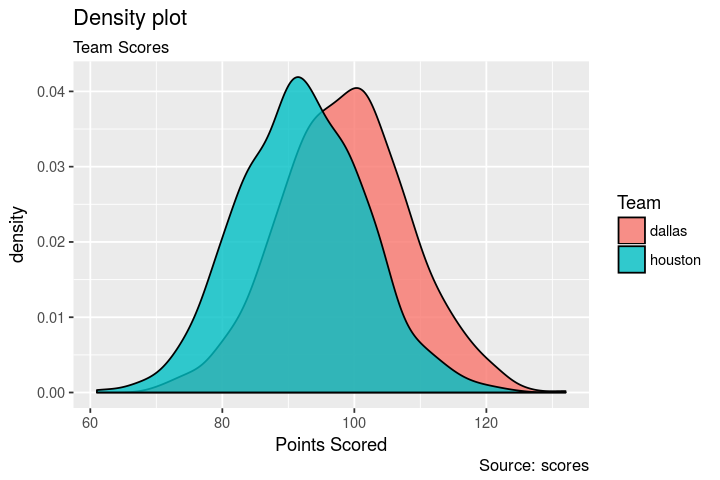

In [16]:

## plot
library(ggplot2)
options(repr.plot.width=6,repr.plot.height=4)
g <- ggplot(scores, aes(points))
g + geom_density(aes(fill=factor(team)), alpha=0.8) + 
    labs(title="Density plot", 
         subtitle="Team Scores",
         caption="Source: scores",
         x="Points Scored",
         fill="Team")
## distributions appear normal because normal approximation to poisson


## fraction of time dallas wins in head to head
## could also compute analytically
mean(d_score > h_score) 


## Model Performance

Is this model any good? It is important to have
* criteria by which a model can be judged
* models (in addition to your own) on which you can make the comparison

For example:
* criteria: absolute error in game score prediction
* simple model: for the next game, predict team X will score whatever its average score has been for all previous games.

Test: Compare the simple model to the Poisson model using a set of games which has not been used to fit the models (i.e. a test set).

[The Signal and the Noise](https://www.amazon.com/Signal-Noise-Many-Predictions-Fail-but/dp/0143125087/ref=sr_1_1?ie=UTF8&qid=1518143380&sr=8-1&keywords=signal+and+the+noise) has some nice discussion on this.